In [1]:
import casatasks
import os 
import sys
from casatasks import simalma, simobserve
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from casatasks import importfits

In [3]:
i = 0
data_dir = 'test_run'
file = 'gauss_cube_' + str(i) + '.fits'
filename = os.path.join(data_dir, file)

In [ ]:
importfits(filename, 'testimage.im')

(1024, 1024)


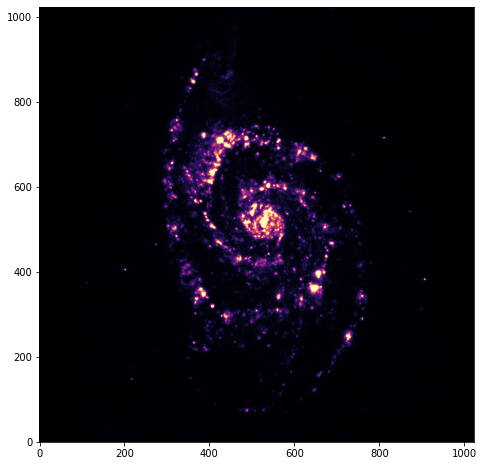

SIMPLE  =                    T /Standard FITS                                   BITPIX  =                  -32 /Floating point (32 bit)                         NAXIS   =                    2                                                  NAXIS1  =                 1024                                                  NAXIS2  =                 1024                                                  BSCALE  =   1.000000000000E+00 /PHYSICAL = PIXEL*BSCALE + BZERO                 BZERO   =   0.000000000000E+00                                                  BMAJ    =   1.388900000000E-05                                                  BMIN    =   1.388900000000E-05                                                  BPA     =   0.000000000000E+00                                                  BTYPE   = 'Intensity'                                                           OBJECT  = '        '           /SOURCE  NAME                                                                            

In [7]:
hdu = fits.open('M51ha.fits')
cube = hdu[0].data
header = hdu[0].header
print(cube.shape)
image = cube
plt.figure(figsize=(8, 8))
plt.imshow(image, origin='lower', cmap='magma')
plt.show()
print(header)

In [ ]:
os.system('curl http://casaguides.nrao.edu/images/3/3f/M51ha.fits.txt -f -o M51ha.fits')

In [8]:
simalma(
    project = 'gauss_cubes_sim_'+str(i),
	dryrun = False,
	skymodel  = 'M51ha.fits',
	inbright = "0.001Jy/pix",
	indirection = "J2000 03h59m59.96s -34d59m59.50s",
	incell = "0.1arcsec",
	incenter = "230GHz",
	inwidth = "10MHz",
	mapsize="",
	antennalist = ["alma.cycle5.3.cfg"],
	totaltime = "720s",
	pwv = 0.8,
	niter= 0,
	overwrite=True
)

2022-05-25 13:07:13	WARN	simalma::::casa	saveinputs not available in casatasks, skipping saving simalma inputs
2022-05-25 13:07:16	WARN	simalma::simalma::casa	------------------------------------------------------------
2022-05-25 13:07:16	WARN	simalma::simalma::casa	Step 1: simulating 12m ALMA array
2022-05-25 13:07:16	WARN	simalma::simalma::casa	------------------------------------------------------------
2022-05-25 13:07:16	SEVERE	simalma::::casa	Task simalma raised an exception of class RuntimeError with the following message: simalma caught an exception in task simobserve


RuntimeError: simalma caught an exception in task simobserve

In [ ]:
from casatasks import exportfits
exportfits(imagename='gauss_cubes_sim_'+str(i)+'/gauss_cubes_sim_'+str(i)+'.alma.cycle5.3.noisy.image', fitsimage='gauss_cubes_sim_'+str(i)+'/gauss_cube_sim_'+str(i)+'.dirty.fits')
	exportfits(imagename='gauss_cubes_sim_'+str(i)+'/gauss_cubes_sim_'+str(i)+'.alma.cycle5.3.skymodel', fitsimage='gauss_cubes_sim_'+str(i)+'/gauss_cube_sim_'+str(i)+'.skymodel.fits')